Assignment 1: Predict diabetes using Perceptron
Student: Pujan Maharjan (a1863495)
Course: Deep Learning Fundamentals

In [53]:
# install required libraries
# !pip install ipywidgets
# !pip install seaborn
# !pip install ipywidgets


In [54]:
import torch
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set()


In [55]:
# Understand Data
# filename = "diabetes.txt"
filename = "diabetes_scale.txt"
X, y = load_svmlight_file(filename)
X = X.toarray()
# reshape y from (768,) to (768,1)
y = y.reshape(-1, 1)
print('X : ', X.shape)
print('Y : ', y.shape)
all_data = np.append(X, y, axis=1)
print('all_data Shape ', all_data.shape)
columns = ['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'BMI', 'Diabetes Pedigree', 'Age', 'Output']
df = pd.DataFrame(all_data, columns=columns)
df

X :  (768, 8)
Y :  (768, 1)
all_data Shape  (768, 9)


,Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree,Age,Output
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,-1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,1.0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,-1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,-1.0
...,...,...,...,...,...,...,...,...,...
763,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000,1.0
764,-0.764706,0.226131,0.147541,-0.454545,-1.000000,0.096870,-0.776260,-0.800000,1.0
765,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000,1.0
766,-0.882353,0.266332,-0.016393,-1.000000,-1.000000,-0.102832,-0.768574,-0.133333,-1.0


In [56]:
desc_data = df.describe().T
desc_data

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,-0.547641,0.396421,-1.0,-0.882353,-0.647059,-0.294118,1.0
Glucose,768.0,0.215020,0.321333,-1.0,-0.005025,0.175879,0.409547,1.0
Blood Pressure,768.0,0.132877,0.317308,-1.0,0.016393,0.180328,0.311475,1.0
Skin Thickness,768.0,-0.585122,0.322267,-1.0,-1.000000,-0.535354,-0.353535,1.0
Insulin,768.0,-0.811349,0.272444,-1.0,-1.000000,-0.927896,-0.699173,1.0
BMI,768.0,-0.046421,0.234997,-1.0,-0.186289,-0.046200,0.090909,1.0
Diabetes Pedigree,768.0,-0.663641,0.282945,-1.0,-0.858455,-0.748506,-0.531811,1.0
Age,768.0,-0.591971,0.392008,-1.0,-0.900000,-0.733333,-0.333333,1.0
Output,768.0,0.302083,0.953903,-1.0,-1.000000,1.000000,1.000000,1.0


In [57]:
desc_data[["mean", "std", "min", "max"]]

,mean,std,min,max
Pregnancies,-0.547641,0.396421,-1.0,1.0
Glucose,0.215020,0.321333,-1.0,1.0
Blood Pressure,0.132877,0.317308,-1.0,1.0
Skin Thickness,-0.585122,0.322267,-1.0,1.0
Insulin,-0.811349,0.272444,-1.0,1.0
BMI,-0.046421,0.234997,-1.0,1.0
Diabetes Pedigree,-0.663641,0.282945,-1.0,1.0
Age,-0.591971,0.392008,-1.0,1.0
Output,0.302083,0.953903,-1.0,1.0


In [58]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnancies        768 non-null    float64
 1   Glucose            768 non-null    float64
 2   Blood Pressure     768 non-null    float64
 3   Skin Thickness     768 non-null    float64
 4   Insulin            768 non-null    float64
 5   BMI                768 non-null    float64
 6   Diabetes Pedigree  768 non-null    float64
 7   Age                768 non-null    float64
 8   Output             768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


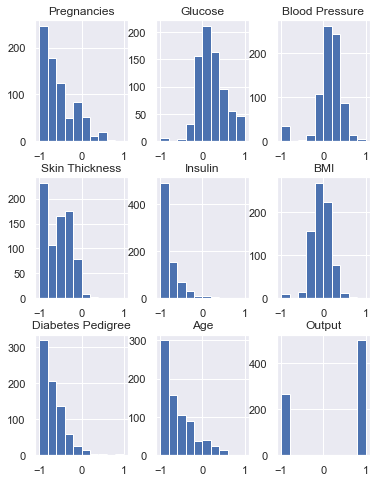

In [59]:
histogram = df.hist(figsize=(6,8))

In [60]:
print(df['Output'].value_counts())

 1.0    500
-1.0    268
Name: Output, dtype: int64


In [61]:
class Perceptron():
    def __init__(self, 
        file_path, 
        weights, 
        loss_function_name, 
        learning_rate, 
        epoch,
        add_bias = False) -> None:
        self.file_path = file_path
        self.weights = weights
        self.loss_function_name = loss_function_name
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.add_bias = add_bias
        self.train_data = None
        self.epochs = []
        self.train_losses = []
        self.validation_losses = []        
        self.train_accuracies = []
        self.validation_accuracies = []
        self.train_validation_y_labels = ['Train', 'Validation']

    def get_features_labels_from_file_data(self):
        X, y = load_svmlight_file(self.file_path)
        # convert X from scipy.sparce.csr.csr_matrix to numpy array
        X = X.toarray()
        # reshape y from (768,) to (768,1)
        y = y.reshape(-1, 1)
        return X,y

    def predict(self, X):
        np_sign_values = np.sign(np.dot(X, self.weights))
        # numpy sign function returns -1, 0, 1,
        # thus for 1 and 0, return 1
        predictions_list = []
        for np_sign_value in np_sign_values:
            if np_sign_value >= 0:
                predictions_list.append(1)
            else:
                predictions_list.append(-1)

        return np.array(predictions_list).reshape(-1,1)

    def zero_one_loss(self, X, y):
        # print('zero one loss X ', X.shape, ', w , ',self.weights.shape)
        xw = np.dot(X, self.weights)
        losses = []
        # if correct prediction, then loss = 0, else loss = 1
        for i in range(len(y)):
            indicator = y[i] * xw[i]
            if indicator < 0:
                losses.append(1)
            else:
                losses.append(0)

        return np.array(losses).reshape(-1,1)

    def perceptron_loss(self, X, y):        
        x_w = np.dot(X, self.weights)
        p_loss_mat = y * x_w
        
        #multiply by minus
        p_loss_mat = -p_loss_mat
        
        zero_column_matrix = np.zeros(p_loss_mat.shape[0]).reshape(-1,1)
        loss_matrix_with_zero_at_first_column = np.append(zero_column_matrix, p_loss_mat, axis=1)
        
        #find max in each row
        perceptron_loss_values = np.amax(loss_matrix_with_zero_at_first_column, axis=1).reshape(-1,1)
        
        return perceptron_loss_values

    def normal_loss(self, X, y):
        normal_loss_values = self.predict(X) - y
        return normal_loss_values

    def l1_loss(self, X, y):
        return abs(self.normal_loss(X,y))

    def l2_loss(self, X, y):
        return (self.predict(X) - y) ** 2

    def add_bias_in_features(self, X_for_bias):
        bias_X = np.ones((X_for_bias.shape[0],1))
        X_for_bias = np.append(bias_X, X_for_bias, axis=1)
        return X_for_bias
        
    def train(self, X_train, y_train, X_val, y_val):
        train_data = []
        if self.add_bias:
            X_train = self.add_bias_in_features(X_train)
            X_val = self.add_bias_in_features(X_val)
            bias_value = np.random.uniform(low=-.1,high=.1, size=1)
            # print('Bias Value ', bias_value)
            bias_W = np.array([bias_value])
            self.weights = np.append(bias_W, self.weights, axis=0)
            
        for epoch_number in range(self.epoch):
            train_loss = None
            validation_loss = None
            train_accuracy = None
          
            if (self.loss_function_name == "zero_one_loss"):
                train_loss = self.zero_one_loss(X_train, y_train)
                validation_loss = self.zero_one_loss(X_val, y_val)  
                                                                         
            elif self.loss_function_name == "perceptron_loss":
                train_loss = self.perceptron_loss(X_train, y_train)
                validation_loss = self.perceptron_loss(X_val, y_val)

            elif self.loss_function_name == "l1_loss":
                train_loss = self.l1_loss(X_train, y_train)
                validation_loss = self.l1_loss(X_val, y_val)

            elif self.loss_function_name == "l2_loss":
                train_loss = self.l2_loss(X_train, y_train)
                validation_loss = self.l2_loss(X_val, y_val)

            else:
                raise "Loss function error " + self.loss_function_name
                
            yxlr = self.learning_rate * y_train * X_train * train_loss
            yxlr_sum = np.sum(yxlr, axis=0).reshape(-1,1)                
            self.weights = self.weights + yxlr_sum

            train_accuracy = self.accuracy(X_train, y_train)
            validation_accuracy = self.accuracy(X_val, y_val)
            train_loss_sum = np.sum(train_loss) / X_train.shape[0]
            validation_loss_sum = np.sum(validation_loss) / X_val.shape[0]

            # print('Epoch ', epoch_number, ', Val accuracy: ', validation_accuracy, ', Val loss: ', validation_loss_sum)
            self.epochs.append(epoch_number)
            self.train_losses.append(train_loss_sum)
            self.validation_losses.append(validation_loss_sum)
            self.train_accuracies.append(train_accuracy)
            self.validation_accuracies.append(validation_accuracy)
            train_data.append({
                'learning_rate': self.learning_rate, 
                'epoch': epoch_number, 
                'train_loss': train_loss_sum, 
                'val_loss': validation_loss_sum,
                'val_accuracy': validation_accuracy,
                'train_accuracy': train_accuracy})

        # print('Training Completed')
        self.train_data = train_data
        return train_data

    def accuracy(self, X_accuracy, y_accuracy):
        predictions_for_accuracy = self.predict(X_accuracy)
        accuracy_score_from_sk_learn = accuracy_score(y_accuracy, predictions_for_accuracy)
        return accuracy_score_from_sk_learn

    def split_train_validation_test(self, X, y, test_split_percentage):
        # reference to split (train/validation/test):
        #  https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
        # print('test_split_percentage ', test_split_percentage)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
            test_size=test_split_percentage, 
            random_state=1, 
            shuffle=True,
            # stratify=y
            )
        # 0.25 * 0.8 = 0.2
        val_split_percentage = test_split_percentage / (1 - test_split_percentage)
        # print('val_split_percentage ', val_split_percentage)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
            test_size=val_split_percentage, 
            random_state=1, 
            shuffle=True,
            # stratify=y_train
            )

        # print('Train: ', X_train.shape[0], ', Val: ', X_val.shape[0], ', Test: ', X_test.shape[0])
        return X_train, X_val, X_test, y_train, y_val, y_test

    def plot_line_graphs(self, x_values, y_values_list, y_labels, title):
        for y_values, y_label in zip(y_values_list, y_labels):
            plt.plot(x_values, y_values, label = y_label)

        plt.legend()
        plt.title(title)
        plt.show()

    def plot_loss_curves(self, title_suffix):        
        y_values_list = [self.train_losses, self.validation_losses]
        self.plot_line_graphs(self.epochs, y_values_list, self.train_validation_y_labels, 'Loss Curves: ' + title_suffix)

    def plot_accuracy_curves(self, title_suffix):
        y_values_list = [self.train_accuracies, self.validation_accuracies]
        self.plot_line_graphs(self.epochs, y_values_list, self.train_validation_y_labels, 'Accuracy Curves: ' + title_suffix)



In [62]:
# Test
# 1. Input Size, split sizes
split_sizes = [.1,.15,.2]
# 2. Weight Random seed
random_seeds = [0, 100, 200]
# 3. Weight pairs
weight_pairs = [(-1,1), (0,1)]
# 4. bias
bias_values = [False, True]
# 5. loss functions
loss_functions = ['zero_one_loss', 'perceptron_loss', 'l1_loss', 'l2_loss']
# 6. Learning rate
learning_rates = [1,0.1,0.001]
# 7. Epoch
epochs = [10,20,30]
default_file_path = 'diabetes_scale.txt'
def train_model(weight_pair, loss_function_name, learning_rate, epoch, split_size,
    bias_value):
    low, high = weight_pair
    np.random.seed(random_seed)
    weights = np.random.uniform(low=low, high = high, size=8).reshape(-1,1)
    perceptron = Perceptron( 
        file_path=default_file_path,
        weights=weights, 
        loss_function_name=loss_function_name, 
        learning_rate=learning_rate, 
        epoch=epoch,
        add_bias=bias_value)
    X, y = perceptron.get_features_labels_from_file_data()
    X_train, X_val, X_test, y_train, y_val, y_test = perceptron.split_train_validation_test(
        X, y, split_size)
    train_data = perceptron.train(X_train, y_train, X_val, y_val)
    # perceptron.plot_loss_curves(default_file_path)
    # perceptron.plot_accuracy_curves(default_file_path)
    # print('train data ', train_data)
    last_train_data = [td for td in train_data if td['epoch'] == epoch - 1][0]
    # print('lt ', last_train_data)
    return {
            'split_size': split_size,
            'random_seed': random_seed,
            'weight_pair': weight_pair,
            'bias_value': bias_value,
            'learning_rate': learning_rate,
            'epoch': epoch,
            'train_accuracy': last_train_data['train_accuracy'],
            'val_accuracy': last_train_data['val_accuracy'],
            'train_loss': last_train_data['train_loss'],
            'val_loss': last_train_data['val_loss'],
            'loss_function_name': loss_function_name
            }

counter = 0
results = []
for split_size in split_sizes:
    for random_seed in random_seeds:
        for weight_pair in weight_pairs:
            for bias_value in bias_values:
                for loss_function_name in loss_functions:
                    for learning_rate in learning_rates:
                        for epoch in epochs:
                            counter += 1
                            # print('counter = ', counter)
                            # Experiment
                            # print('Experiment ',
                            #     ', split_size: ', split_size, 
                            #     ', random_seed: ', random_seed,
                            #     ', weight_pair: ', weight_pair,
                            #     ', bias_value: ', bias_value,
                            #     ', loss_function_name: ', loss_function_name,
                            #     ', learning_rate ', learning_rate,
                            #     ', epoch: ', epoch)
                            result = train_model(
                                weight_pair, 
                                loss_function_name, 
                                learning_rate, 
                                epoch, 
                                split_size,
                                bias_value)

                            results.append(result)


                        
                

In [63]:
results_df = pd.DataFrame(results)
# top 3 records
redf = results_df.sort_values(by=["val_accuracy"], ascending=False)[0:3].T
redf

,727,178,287
split_size,0.15,0.1,0.1
random_seed,200,100,100
weight_pair,"(-1, 1)","(-1, 1)","(0, 1)"
bias_value,False,False,True
learning_rate,0.001,0.001,0.001
epoch,20,20,30
train_accuracy,0.731343,0.752443,0.758958
val_accuracy,0.844828,0.844156,0.844156
train_loss,0.264925,1.387622,1.009772
val_loss,0.163793,0.935065,1.350649
